In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import time

In [19]:
class SineNoiseDataset(Dataset):
    def __init__(self, num_samples=1000, seq_length=50):
        self.X = []
        self.y = []
        for _ in range(num_samples):
            if np.random.rand() > 0.5:
                freq = np.random.uniform(1, 3)
                x = np.sin(np.linspace(0, freq * np.pi, seq_length))
                label = 0
            else:
                x = np.random.normal(0, 1, seq_length)
                label = 1
            self.X.append(x)
            self.y.append(label)

        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(self.y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SineNoiseDataset()
test_dataset = SineNoiseDataset(300)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.Wx = nn.Linear(input_size, 4 * hidden_size)
        self.Wh = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, init_states=None):
        B, T, _ = x.size()
        h = torch.zeros(B, self.hidden_size, device=x.device) if init_states is None else init_states[0]
        c = torch.zeros(B, self.hidden_size, device=x.device) if init_states is None else init_states[1]

        outputs = []
        for t in range(T):
            x_t = x[:, t]
            gates = self.Wx(x_t) + self.Wh(h)
            i, f, g, o = gates.chunk(4, dim=1)
            i = torch.sigmoid(i)
            f = torch.sigmoid(f)
            g = torch.tanh(g)
            o = torch.sigmoid(o)

            c = f * c + i * g
            h = o * torch.tanh(c)
            outputs.append(h.unsqueeze(1))

        return torch.cat(outputs, dim=1), (h, c)

In [21]:
class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.Wx = nn.Linear(input_size, 3 * hidden_size)
        self.Wh = nn.Linear(hidden_size, 3 * hidden_size)

    def forward(self, x, h=None):
        B, T, _ = x.size()
        h = torch.zeros(B, self.hidden_size, device=x.device) if h is None else h

        outputs = []
        for t in range(T):
            x_t = x[:, t]
            gates = self.Wx(x_t) + self.Wh(h)
            z, r, h_tilde = gates.chunk(3, dim=1)

            z = torch.sigmoid(z)
            r = torch.sigmoid(r)
            h_tilde = torch.tanh(h_tilde + r * self.Wh(h).chunk(3, dim=1)[2])

            h = (1 - z) * h + z * h_tilde
            outputs.append(h.unsqueeze(1))

        return torch.cat(outputs, dim=1), h

In [22]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_classes=2):
        super().__init__()
        self.rnn = CustomLSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (h, _) = self.rnn(x)
        return self.fc(h)


class GRUClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_classes=2):
        super().__init__()
        self.rnn = CustomGRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, h = self.rnn(x)
        return self.fc(h)

In [26]:
def train_and_eval(model, train_loader, test_loader, epochs=15, device='cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    train_accs, test_accs = [], []

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        correct = total = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        train_acc = correct / total
        train_accs.append(train_acc)

        # Evaluation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        test_acc = correct / total
        test_accs.append(test_acc)
        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}, Test Acc = {test_acc:.2f}")

    elapsed = time.time() - start_time
    return train_accs, test_accs, elapsed

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lstm_model = LSTMClassifier()
gru_model = GRUClassifier()

print("\n--- Training Custom LSTM ---")
lstm_train_acc, lstm_test_acc, lstm_time = train_and_eval(lstm_model, train_loader, test_loader, device=device)

print("\n--- Training Custom GRU ---")
gru_train_acc, gru_test_acc, gru_time = train_and_eval(gru_model, train_loader, test_loader, device=device)


--- Training Custom LSTM ---
Epoch 1: Train Acc = 0.70, Test Acc = 0.82
Epoch 2: Train Acc = 0.84, Test Acc = 0.89
Epoch 3: Train Acc = 0.97, Test Acc = 1.00
Epoch 4: Train Acc = 0.97, Test Acc = 0.95
Epoch 5: Train Acc = 0.95, Test Acc = 0.99
Epoch 6: Train Acc = 0.99, Test Acc = 1.00
Epoch 7: Train Acc = 1.00, Test Acc = 1.00
Epoch 8: Train Acc = 1.00, Test Acc = 1.00
Epoch 9: Train Acc = 1.00, Test Acc = 1.00
Epoch 10: Train Acc = 1.00, Test Acc = 1.00
Epoch 11: Train Acc = 1.00, Test Acc = 1.00
Epoch 12: Train Acc = 1.00, Test Acc = 1.00
Epoch 13: Train Acc = 1.00, Test Acc = 1.00
Epoch 14: Train Acc = 1.00, Test Acc = 1.00
Epoch 15: Train Acc = 1.00, Test Acc = 1.00

--- Training Custom GRU ---
Epoch 1: Train Acc = 0.75, Test Acc = 0.93
Epoch 2: Train Acc = 0.97, Test Acc = 1.00
Epoch 3: Train Acc = 1.00, Test Acc = 0.99
Epoch 4: Train Acc = 1.00, Test Acc = 1.00
Epoch 5: Train Acc = 0.97, Test Acc = 1.00
Epoch 6: Train Acc = 1.00, Test Acc = 1.00
Epoch 7: Train Acc = 1.00, Test 

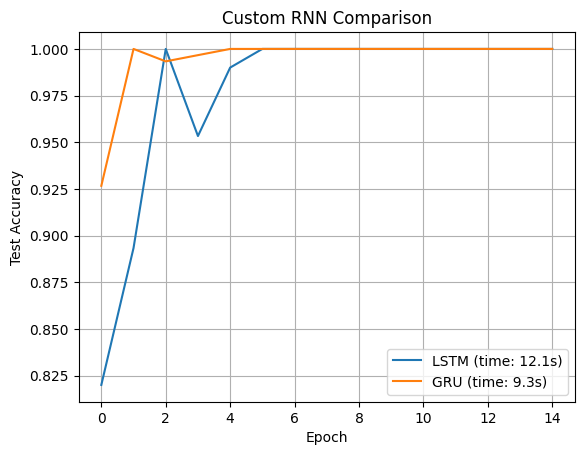


✅ Итоговое сравнение:
LSTM: Accuracy = 100.00%, Time = 12.1 sec
GRU : Accuracy = 100.00%, Time = 9.3 sec


In [ ]:
plt.plot(lstm_test_acc, label=f'LSTM (time: {lstm_time:.1f}s)')
plt.plot(gru_test_acc, label=f'GRU (time: {gru_time:.1f}s)')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Custom RNN Comparison')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n✅ Итоговое сравнение:")
print(f"LSTM: Accuracy = {lstm_test_acc[-1]*100:.2f}%, Time = {lstm_time:.1f} sec")
print(f"GRU : Accuracy = {gru_test_acc[-1]*100:.2f}%, Time = {gru_time:.1f} sec")